## Load dataset

In [1]:
import scanpy as sc
import scvelo as scv

# data = scv.datasets.pancreas(file_path=r"C:\Users\evanlee\Documents\Research_datasets\Pancreas\endocrinogenesis_day15.h5ad")
data = scv.datasets.pancreas(file_path='/Users/evanli/Documents/Research_datasets/endocrinogenesis_day15.h5ad')

label = data.obs['clusters'].tolist()

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data.shape

(3696, 27998)

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy

In [4]:
data.obs.head()

,clusters_coarse,clusters,S_score,G2M_score
index,,,,
AAACCTGAGAGGGATA,Pre-endocrine,Pre-endocrine,-0.224902,-0.252071
AAACCTGAGCCTTGAT,Ductal,Ductal,-0.014707,-0.232610
AAACCTGAGGCAATTA,Endocrine,Alpha,-0.171255,-0.286834
AAACCTGCATCATCCC,Ductal,Ductal,0.599244,0.191243
AAACCTGGTAAGTGGC,Ngn3 high EP,Ngn3 high EP,-0.179981,-0.126030


In [33]:
top3 = data[:3]
type(top3)

anndata._core.anndata.AnnData

In [34]:
top3_X = top3.X.toarray()
type(top3_X)

numpy.ndarray

In [42]:
def jaccard_dense_mat(X, idx_1, idx_2):
    a = X[idx_1]
    b = X[idx_2]
    a_idx = []
    b_idx = []
    a_count = b_count = 0
    for i in range(len(a)):
        if a[i] != 0:
            a_idx.append(i)
            a_count += 1
        if b[i] != 0:
            b_idx.append(i)
            b_count += 1
    
    print(a_count, b_count)
    inter = list(set(a_idx).intersection(b_idx))
    union = list(set(a_idx).union(b_idx))
    print('inter', len(inter))
    print('union', len(union))
    jaccard = len(inter) / len(union)
    return jaccard

In [43]:
j_01 = jaccard_dense_mat(top3_X, 0, 1)
j_01

2356 2613
inter 1093
union 3876


0.2819917440660475

In [47]:
j_12 = jaccard_dense_mat(top3_X, 1, 2)
j_12

2613 1984
inter 937
union 3660


0.25601092896174865

In [48]:
j_02 = jaccard_dense_mat(top3_X, 0, 2)
j_02

2356 1984
inter 935
union 3405


0.2745961820851689

In [7]:
import numpy as np
from scipy.sparse import csr_matrix
from tqdm import tqdm

def pairwise_jaccard(adata, idx_1, idx_2):
    a = adata.X[idx_1].tocsr()
    b = adata.X[idx_2].tocsr()
    
    # get the index of nonzero values in a and b
    a_nonzero_idx = a.indices
    b_nonzero_idx = b.indices
    # print(len(a_nonzero_idx), len(b_nonzero_idx))

    # Intersection and union of nonzero indices
    intersection = len(np.intersect1d(a_nonzero_idx, b_nonzero_idx))
    union = len(np.union1d(a_nonzero_idx, b_nonzero_idx))
    # print('intersection', intersection)
    # print('union', union)
    
    # Intersection and Union using efficient sparse operations
    # intersection = a.multiply(b).count_nonzero()
    # union = a + b
    # union.data = np.where(union.data > 0, 1, 0)  # if value > 0, set to 1, else set to 0
    # union = union.count_nonzero()

    # Calculate Jaccard Index
    jaccard = intersection / union if union != 0 else 0

    return jaccard

# To compute the Jaccard matrix for a subset of cells
def compute_jaccard_matrix(adata, n_samples):
    jaccard_matrix = np.zeros((n_samples, n_samples))
    # for i in tqdm(range(n_samples), desc='Computing Jaccard indices'):
    for i in range(n_samples):
        for j in range(i, n_samples):
            jaccard = pairwise_jaccard(adata, i, j)
            jaccard_matrix[i, j] = jaccard
            jaccard_matrix[j, i] = jaccard

    return jaccard_matrix


In [8]:
st = time.time()
print(pairwise_jaccard(data, 0, 1))
et = time.time()
print(et - st)

2356 2613
intersection 1093
union 3876
0.2819917440660475
0.0034439563751220703


In [9]:
st = time.time()
print(pairwise_jaccard(data, 0, 2))
et = time.time()
print(et - st)

2356 1984
intersection 935
union 3405
0.2745961820851689
0.0014858245849609375


In [10]:
pairwise_jaccard(data, 1, 2)

2613 1984
intersection 937
union 3660


0.25601092896174865

In [ ]:

# Usage
n_samples = data.shape[0]  # or any smaller number if you want to limit the computation
jaccard_matrix = compute_jaccard_matrix(data, n_samples)


In [ ]:
jaccard_matrix.shape

In [ ]:
np.savetxt("Pancreas_jaccard_matrix_1.csv", jaccard_matrix, delimiter=",")

## Multi-processing

In [5]:
from sklearn.utils import gen_batches

n_samples = data.shape[0]
list(gen_batches(n_samples, n_samples // 8))

[slice(0, 462, None),
 slice(462, 924, None),
 slice(924, 1386, None),
 slice(1386, 1848, None),
 slice(1848, 2310, None),
 slice(2310, 2772, None),
 slice(2772, 3234, None),
 slice(3234, 3696, None)]

In [6]:
batches = list(gen_batches(20, 20 // 4))
print(type(batches[0]))
for idx in batches:
    print(idx)

<class 'slice'>
slice(0, 5, None)
slice(5, 10, None)
slice(10, 15, None)
slice(15, 20, None)


In [7]:
start = batches[-1].start
end = batches[-1].stop
for i in range(start, end):
    for j in range(i, 20):
        print(i, j)

15 15
15 16
15 17
15 18
15 19
16 16
16 17
16 18
16 19
17 17
17 18
17 19
18 18
18 19
19 19


In [18]:
import multiprocessing as mp
from sklearn.utils import gen_batches
from pathos.multiprocessing import ProcessingPool

def pairwise_jaccard(adata, idx_1, idx_2):
    a = adata.X[idx_1].tocsr()
    b = adata.X[idx_2].tocsr()
    
    intersection = len(np.intersect1d(a.indices, b.indices))
    union = len(np.union1d(a.indices, b.indices))
    jaccard = intersection / union if union != 0 else 0
    return jaccard

def compute_jaccard_matrix_batch(args):
    adata, batch_idx = args
    print('=====Starting batch:', batch_idx)
    n_samples = adata.shape[0]
    start_idx = batch_idx.start
    stop_idx = batch_idx.stop
    # jaccard_matrix_batch = np.zeros((n_samples, n_samples))
    jaccard_matrix_batch = np.zeros((stop_idx - start_idx, n_samples))
    for i in range(start_idx, stop_idx):
        for j in range(i, n_samples):
            jaccard = pairwise_jaccard(adata, i, j)
            jaccard_matrix_batch[i, j] = jaccard
            # jaccard_matrix_batch[j, i] = jaccard
    return jaccard_matrix_batch

def parallel_jaccard(adata, num_splits=8):
    n_samples = adata.shape[0]
    batches = list(gen_batches(n_samples, n_samples // num_splits))
    
    # Map the compute function to each batch of indices
    # pool = multiprocessing.Pool(processes=num_splits)
    # results = pool.starmap(compute_jaccard_matrix, [(adata, batch) for batch in batches])
    # pool.close()
    # pool.join()
    with ProcessingPool(processes=num_splits) as pool:
        results = pool.map(compute_jaccard_matrix_batch, [(adata, batch) for batch in batches])

    return results
    # Combine results
    # full_matrix = np.zeros((n_samples, n_samples))
    # for i, idx in enumerate(indices):
    #     full_matrix[np.ix_(idx, idx)] = results[i]
    result_dict = {}
    for i, idx in enumerate(batches):
        result_dict[idx] = results[i]

    return result_dict

In [11]:
jaccard_matrix_para = parallel_jaccard(data)


In [12]:
type(jaccard_matrix_para)

list

In [14]:
type(jaccard_matrix_para[0])

numpy.ndarray

In [15]:
jaccard_matrix_para[0].shape

(3696, 3696)

In [17]:
os.chdir('/Users/evanli/Downloads/temp0509/Pancreas_Jaccard')
i = 0
for mat in jaccard_matrix_para:
    np.savetxt(f"Pancreas_jaccard_matrix_{i}.csv", mat, delimiter=",")
    i += 1

In [19]:
# slight modify
jaccard_matrix_para2 = parallel_jaccard(data)


IndexError: index 462 is out of bounds for axis 0 with size 462

## Pancreas_jaccard_matrix_1

In [54]:
pancreas_matrix = pd.read_csv(r"C:\Users\evanlee\Documents\Research_datasets\larger_files_100M\Pancreas_jaccard_matrix_1.csv", header=None)
pancreas_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,3686,3687,3688,3689,3690,3691,3692,3693,3694,3695
0,1.000000,0.281992,0.274596,0.281258,0.279630,0.284236,0.322736,0.286192,0.296943,0.278922,...,0.285937,0.271801,0.293593,0.278644,0.311831,0.326824,0.292937,0.264040,0.318106,0.312383
1,0.281992,1.000000,0.256011,0.337488,0.278219,0.343825,0.314057,0.356837,0.338734,0.328210,...,0.326801,0.276155,0.349007,0.251384,0.304832,0.320493,0.316347,0.314184,0.311505,0.296836
2,0.274596,0.256011,1.000000,0.247168,0.257494,0.258302,0.288374,0.254710,0.256318,0.253154,...,0.257268,0.249839,0.264607,0.267427,0.279740,0.280574,0.260368,0.248346,0.289586,0.301665
3,0.281258,0.337488,0.247168,1.000000,0.267433,0.347485,0.316067,0.358319,0.364387,0.326551,...,0.315346,0.260085,0.347265,0.247579,0.301469,0.316827,0.307104,0.297883,0.314467,0.294498
4,0.279630,0.278219,0.257494,0.267433,1.000000,0.282045,0.302241,0.276340,0.275870,0.286497,...,0.281908,0.284953,0.310181,0.260098,0.304801,0.321308,0.324532,0.273706,0.302111,0.289117


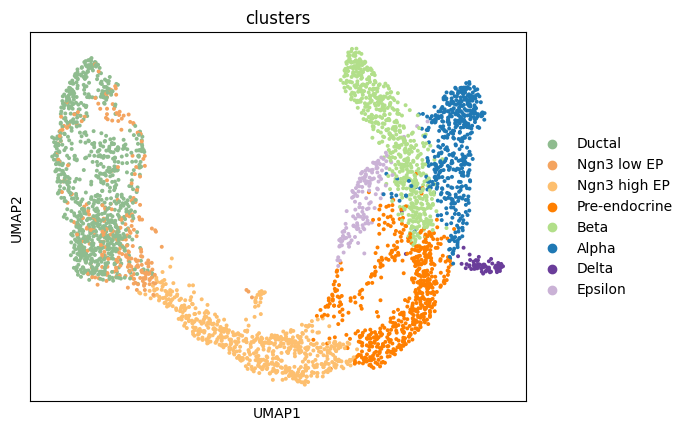

In [60]:
data.obsp['distances'] = pancreas_matrix.values
sc.pl.umap(data, color='clusters')